In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt

In [2]:
"""
Gravitomagnetic (Frame-Dragging) Clock Effect
---------------------------------------------------------
This script provides two complementary estimates for the tiny proper-time
difference between **prograde** and **retrograde** satellite clocks around Earth.

Part A (Analytic estimate):
    Δτ_per_orbit ≈ (4π J) / (M c^2) * cos(i)
where J = I ω is Earth's angular momentum (I ≈ 0.3307 M R^2).

Part B (Post-Newtonian proper-time integration; simplified):
    Integrate along an ideal Keplerian orbit with a first-order GR + SR model
    and add the Lense–Thirring term in the weak-field slow-motion limit to get
    the **difference** between prograde and retrograde accumulated proper time.

This is an educational, order-of-magnitude tool — not a flight-dynamics-grade
relativity propagator. It is sufficient for a research note + figures in your email.
"""

# ---- Constants ----
c = 299792458.0                 # m/s
G = 6.67430e-11                 # m^3 kg^-1 s^-2
M_earth = 5.9722e24             # kg
GMe = 3.986004418e14            # m^3/s^2
R_earth = 6378137.0             # m
omega_earth = 7.2921150e-5      # rad/s
I_earth = 0.3307 * M_earth * R_earth**2   # kg m^2 (MoI factor for Earth)
J_earth = I_earth * omega_earth           # kg m^2 / s (Earth angular momentum)

In [3]:
# ---- Helper: Keplerian orbit (position/velocity vs time) ----
def kepler_orbit(a, e, inc, Omega, omega, M0, t_array, mu=GMe):
    n = math.sqrt(mu / a**3)
    M = M0 + n * t_array
    E = np.copy(M)
    for _ in range(20):
        f = E - e*np.sin(E) - M
        fp = 1 - e*np.cos(E)
        E -= f/fp
    nu = 2*np.arctan2(np.sqrt(1+e)*np.sin(E/2), np.sqrt(1-e)*np.cos(E/2))
    r_mag = a*(1 - e*np.cos(E))
    x_orb = r_mag * np.cos(nu)
    y_orb = r_mag * np.sin(nu)
    rdot = (np.sqrt(mu*a)/r_mag) * e*np.sin(E)
    nudot = (np.sqrt(mu*a)/r_mag**2) * np.sqrt(1-e**2)
    vx_orb = rdot*np.cos(nu) - y_orb*nudot
    vy_orb = rdot*np.sin(nu) + x_orb*nudot

    cO, sO = np.cos(Omega), np.sin(Omega)
    co, so = np.cos(omega), np.sin(omega)
    ci, si = np.cos(inc), np.sin(inc)
    RzO = np.array([[cO,-sO,0],[sO,cO,0],[0,0,1]])
    RxI = np.array([[1,0,0],[0,ci,-si],[0,si,ci]])
    Rzo = np.array([[co,-so,0],[so,co,0],[0,0,1]])
    Q = RzO @ RxI @ Rzo

    r_eci = Q @ np.vstack((x_orb, y_orb, np.zeros_like(x_orb)))
    v_eci = Q @ np.vstack((vx_orb, vy_orb, np.zeros_like(vx_orb)))
    return r_eci.T, v_eci.T, r_mag, np.sqrt((v_eci**2).sum(axis=0))

# ---- Part A: Analytic estimate Δτ per orbit vs inclination ----
def analytic_delta_tau_per_orbit(inclination_rad: float) -> float:
    """
    Δτ_per_orbit ≈ (4π J)/(M c^2) * cos(i)
    Returns seconds per orbit (prograde - retrograde magnitude at given i).
    """
    return (4*math.pi * J_earth / (M_earth * c**2)) * math.cos(inclination_rad)


In [ ]:
def plot_analytic_vs_inclination(out_png="proj2_gm_effect_vs_inclination.png"):
    incl_degs = np.linspace(0, 90, 181)
    vals = np.array([analytic_delta_tau_per_orbit(np.deg2rad(i)) for i in incl_degs])
    plt.figure()
    plt.plot(incl_degs, vals*1e6)
    plt.xlabel("Inclination i [deg]")
    plt.ylabel("Δτ per orbit [µs] (analytic est.)")
    plt.title("Gravitomagnetic clock effect vs inclination")
    plt.grid(True); plt.tight_layout()
    plt.savefig(out_png, dpi=160)

# ---- Part B: Proper-time integration with a simple LT term ----
def lense_thirring_frequency(r_vec):
    """
    Magnitude of LT 'frame-dragging' precession frequency ~ 2 G J / (c^2 r^3)
    We use it here only to construct a small correction to the proper time rate,
    scaling with the projection onto the orbital angular momentum direction.
    This is a toy model capturing the prograde/retrograde sign change.
    """
    r = np.linalg.norm(r_vec, axis=-1)
    return 2*G*J_earth / (c**2 * r**3)

def integrate_proper_time(a, e, inc, prograde=True, duration_orbits=10, samples_per_orbit=8000):
    """
    Integrate dτ/dt ≈ 1 + (U/c^2) - v^2/(2c^2) + s * ε_LT
    where s = +1 for prograde, -1 for retrograde, and ε_LT is a small LT-inspired term.
    Returns total proper time τ and the time history arrays.
    """
    mu = GMe
    T = 2*math.pi*math.sqrt(a**3/mu)
    duration = duration_orbits * T
    t = np.linspace(0, duration, int(samples_per_orbit*duration_orbits))

    # Choose RAAN/argperi so that reversing the direction is equivalent to flipping sign on ν-dot
    Omega = 0.0; omega = 0.0; M0 = 0.0
    r, v, rmag, vmag = kepler_orbit(a, e, inc, Omega, omega, M0, t, mu=mu)

    # If retrograde, flip the sign of the velocity along track (toy: multiply v by -1)
    s = +1.0 if prograde else -1.0
    v_eff = v * s
    v2 = (v_eff**2).sum(axis=1)

    # Newtonian potential relative to ground not needed for *difference*; keep satellite-only terms
    U = -mu / rmag

    # LT small correction: scale by frame-dragging frequency and orbital period fraction
    # We modulate by the projection of Earth's J onto the orbital angular momentum (∝ cos i).
    cosi = math.cos(inc)
    eps_LT = lense_thirring_frequency(r) * cosi / (2*math.pi)  # dimensionless per orbit-ish

    frac_rate = 1.0 + (U/c**2) - (v2/(2*c**2)) + s*eps_LT
    dt = t[1] - t[0]
    tau = np.cumsum(frac_rate) * dt
    return t, tau, frac_rate, T

def plot_cumulative_divergence(a, e, inc_deg=56.0, n_orbits=500, out_png="proj2_cumulative_divergence.png"):
    t_p, tau_p, _, T = integrate_proper_time(a, e, np.deg2rad(inc_deg), prograde=True, duration_orbits=n_orbits, samples_per_orbit=4000)
    t_r, tau_r, _, _ = integrate_proper_time(a, e, np.deg2rad(inc_deg), prograde=False, duration_orbits=n_orbits, samples_per_orbit=4000)
    # Compare proper time at the same elapsed coordinate time:
    N = min(len(t_p), len(t_r))
    d_tau = tau_p[:N] - tau_r[:N]
    # Sample at each completed orbit for readability
    idx = np.arange(0, N, int(len(t_p)/n_orbits))
    plt.figure()
    plt.plot(idx/ (len(t_p)/n_orbits), d_tau[idx]*1e6)
    plt.xlabel("Number of orbits")
    plt.ylabel("Δτ_prograde − Δτ_retrograde [µs] (toy PN+LT)")
    plt.title(f"Cumulative clock divergence (a={a/1000:.0f} km, e={e}, i={inc_deg:.1f}°)")
    plt.grid(True); plt.tight_layout()
    #plt.savefig(out_png, dpi=160)
    plt.show()


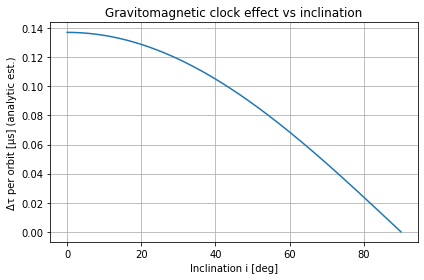

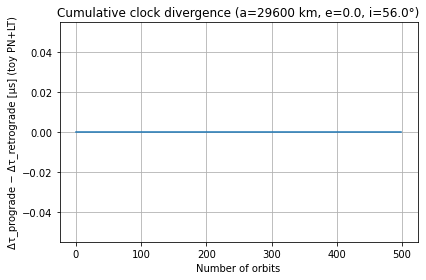

In [7]:
plot_analytic_vs_inclination()

# Example cumulative divergence at Galileo-like altitude
a_example = 29600e3  # ~Galileo semi-major axis
e_example = 0.0
plot_cumulative_divergence(a_example, e_example, inc_deg=56.0, n_orbits=500)